In [156]:
# !pip install textacy
# !pip install fuzzywuzzy
# !pip install TextBlob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [160]:
import pandas as pd
import nltk
import re

from textacy.preprocessing.resources import RE_URL
from textacy.preprocessing.resources import RE_SHORT_URL
from textacy.preprocessing.replace import urls,numbers,emails,hashtags,currency_symbols,emojis
from nltk.corpus import words
import difflib
import pickle
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from textblob import TextBlob
from nltk.corpus import wordnet
import pickle 

In [49]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [106]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
data=pd.read_csv('/content/drive/MyDrive/Team Blue NLP/train.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [108]:
data.shape

(159571, 8)

In [109]:
# test_data=pd.read_csv('/content/drive/MyDrive/Team Blue NLP/test.csv')
# test_data.head()

##EDA

In [ ]:
data.info()

Text(0.5, 1.0, 'Distribution of comment lengths')

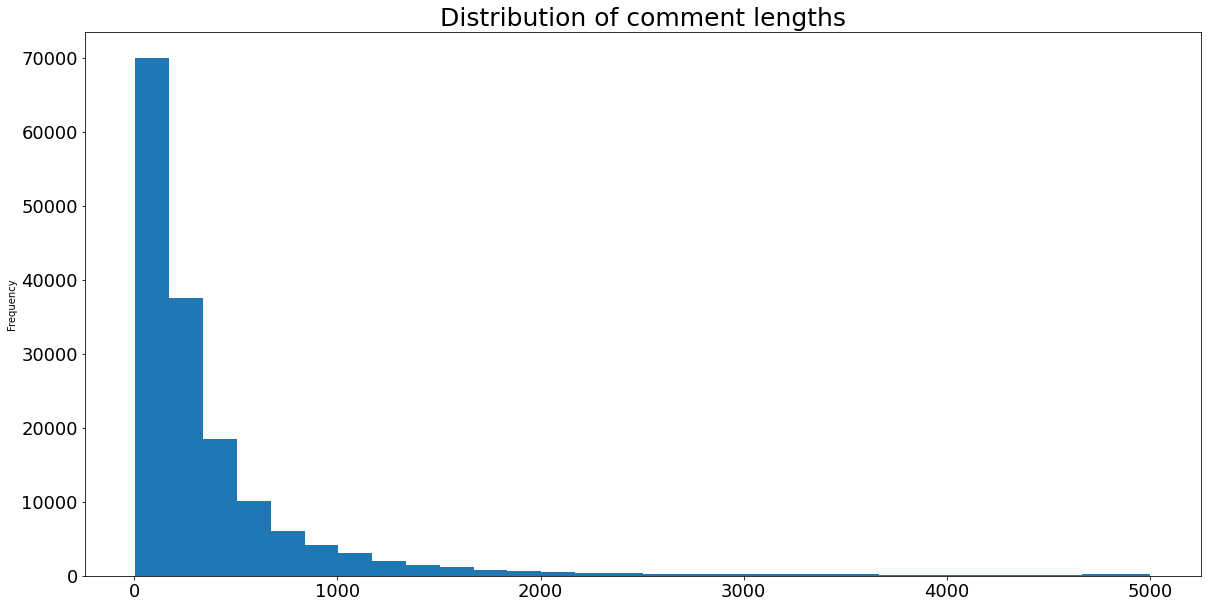

In [110]:
#lengths of comments
data['comment_text'].apply(len).plot(kind = 'hist',figsize = (20,10),fontsize = 18,bins = 30)
plt.title("Distribution of comment lengths",fontsize = 25)

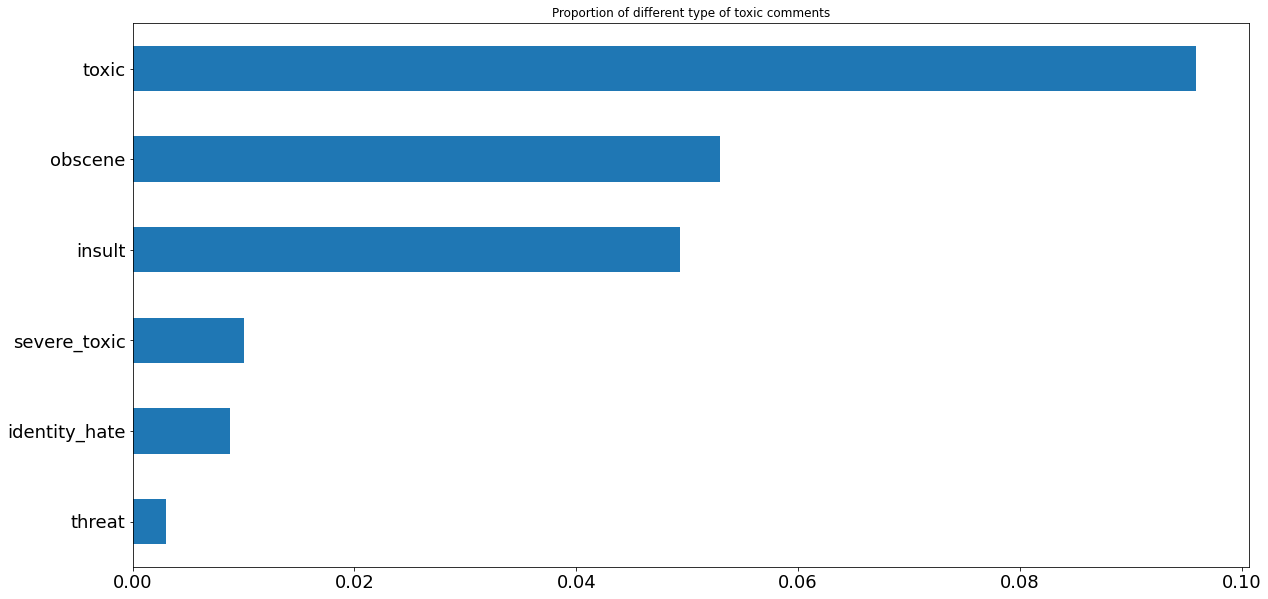

In [111]:
data[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].mean().sort_values().plot(kind = 'barh',figsize = (20,10),fontsize = 18, title = "Proportion of different type of toxic comments")
# plt.title("Proportion")

Text(0.5, 1.0, 'Distribution of Toxic Comments')

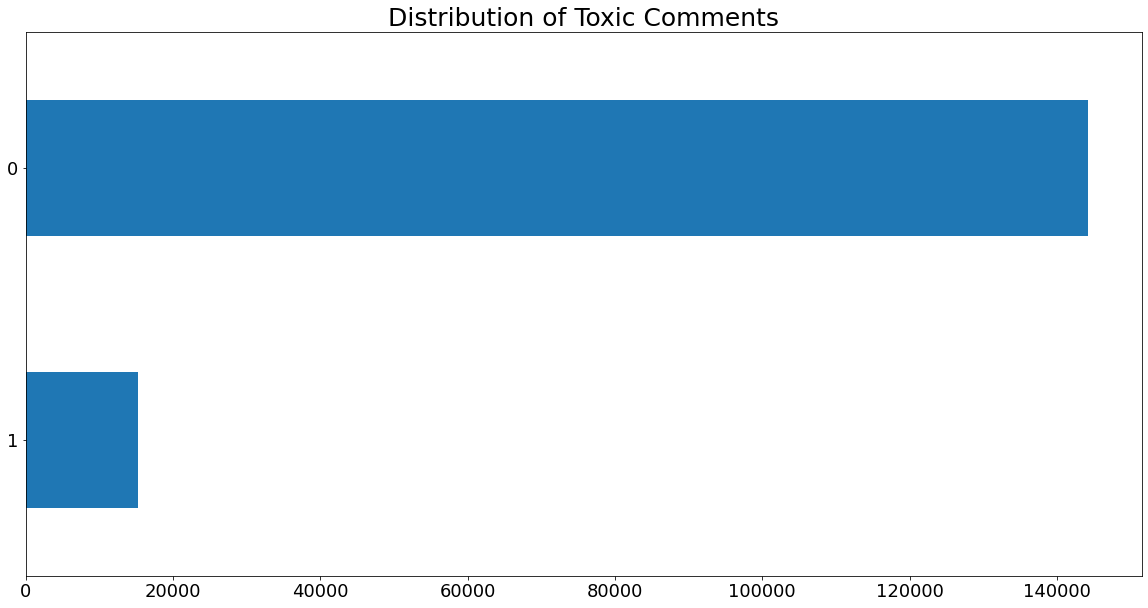

In [112]:
(data['toxic'].value_counts(normalize = False)).sort_values().plot(kind = 'barh',figsize = (20,10),fontsize = 18, title = "Distribution of Toxic Comments")
plt.title("Distribution of Toxic Comments",fontsize = 25)

In [113]:
data['toxic'].value_counts(normalize = True)

0    0.904156
1    0.095844
Name: toxic, dtype: float64

##Cleaning and Preprocessing

In [114]:
#initially thought about regex groupings for online jargons 
#online_jargons = ['jeez','LOL','ASAP','TTYL','IMO','ILY','IMU','LMAO','BFF','POV','WTF','ASL','IRL','PPL','IDK','OMG','FYI']

### Avg capital letters count

In [115]:
data['avg_count_caps'] = data['comment_text'].apply(lambda x: sum([i.isupper() for i in x])/len(x))

In [179]:
data[['comment_text','avg_count_caps','toxic']].sort_values(by = 'avg_count_caps').tail(100)

,comment_text,avg_count_caps,toxic
77159,MEXICANS SUCK MEXICANS SUCK MEXICANS SUCK MEXI...,0.856828,1
77202,NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGG...,0.856913,1
83018,UPDATED WITH REFERENCES NOW!,0.857143,0
25605,ANTI NORTH EAST INDIA EDITOR,0.857143,0
54528,EPONA EPONA EPONA EPONA EPONA EPONA,0.857143,0
...,...,...,...
71584,MRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR...,0.962963,0
106067,FFFFFFFFFFFFFFFUUUUUUUUUUUUUUUUUUUUUUUCCCCCCCC...,0.965116,1
29580,YO MOMA IS COOL AND FARTS 247 \n\nHI BYE GIGOW...,0.969499,1
34637,shut up you cunt\nWWWWWWWWWWWWWWWWWWWWWWWWWWWW...,0.995930,1


In [117]:
def clean_punc(sentence):
  #should run this in the last otherwise will mess with other regex patterns like ip address time etc
  cleaned=re.sub(r'[|(|)|\\|/|"|!|?|,|.|~|*|:|{|}|=|•]',' ',sentence)
  cleaned=re.sub(r"'",' ',cleaned)
  # cleaned=re.sub(r'[-]',' ',cleaned)
  return cleaned

### Contractions

In [118]:
#following snippet from https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
data['comment_cleaned']=data['comment_text'].apply(lambda x:expand_contractions(x))


### Regex Grouping and other cleaning

In [119]:
#Using Textacy to clean standardize, urls, emails, hastags, currency symbols, emojis
data['comment_cleaned'] = data['comment_cleaned'].\
                                  apply(urls).\
                                  apply(emails).\
                                  apply(hashtags).\
                                  apply(currency_symbols).\
                                  apply(emojis)

In [120]:
data['comment_cleaned']=[re.sub(r'\n|"|\xa0|\\|-|\/|]|\[|=|\)|\(',' ',x) for x in data.comment_cleaned] # Special characters

In [121]:
data['comment_cleaned']=[re.sub(r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b','_IPADDRESS_',x) for x in data.comment_cleaned] # IP address 

In [122]:
data['comment_cleaned']=[re.sub(r'((\d{1,2})?:(\d{1,2})?:?(\d{1,2})?)? *(\d{1,4})? *\b(Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)\b +(\d{1,2})?(\w{2})? *(\d{4})?',' _DATETIME_ ',x,flags=re.IGNORECASE) for x in data.comment_cleaned] # TimeStamp 

In [123]:
#_YEAR_ / _DATETIME_ 1990s 1990
data['comment_cleaned'] = data['comment_cleaned'].str.replace(r'\d{4}s?','_DATETIME_',regex = True)
#time
data['comment_cleaned'] = data['comment_cleaned'].str.replace(r'\b\d{2,}:\d{2,}\b','_TIME_',regex = True)
data['comment_cleaned'] = data['comment_cleaned'].apply(numbers)
#characters in other languages
data['comment_cleaned'] = data['comment_cleaned'].str.replace(r'[\u4e00-\u9fff]',' ',regex = True) #The 4E00—9FFF range covers CJK Unified Ideographs (CJK=Chinese, Japanese and Korean).

# \^_\^
data['comment_cleaned'] = data['comment_cleaned'].str.replace(r'(?:\^_\^)|(?:O_o)|(?:o_o)|(?:o_O)|(?:O_O)|(?:-_-)','_EMOJI_',regex = True)
#got following regex from https://regex101.com/r/aM3cU7/4  for matching emojis made using punctuations and letters
# /(\:\w+\:|\<[\/\\]?3|[\(\)\\\D|\*\$][\-\^]?[\:\;\=]|[\:\;\=B8][\-\^]?[3DOPp\@\$\*\\\)\(\/\|])(?=\s|[\!\.\?]|$)/g
#15 years old, son kid etc
data['comment_cleaned'] = data['comment_cleaned'].replace(r'\b(?:(?:\d+ (?:yr|years?) old)|sons?|daughters?|kids?|child(?:ren)?)\b','_CHILD_',regex = True)
#Non english characters
data['comment_cleaned'] = data['comment_cleaned'].str.replace(r'[^\x00-\x7F]',' ',regex = True)
#\u200f


In [124]:

#characters in other languages
#new column with count of capital case
#15:12 timestamps
#1990 year  1990s
#~~~~
#slangs %_CUR_#@ https://github.com/mogade/badwords/blob/master/en.txt
#™№1185©
#%3AXM8_rifle&diff; 193022803&oldid;  F3UwF1eqb0AC&lpg;
#'''''' {}
#id=F3UwF1eqb0AC&lpg;=PP1&pg;=PA70#v=onepage&q;&f;=false
#4 year old, 15 years old
#9pmET
#יג  וּמִצְרַיִם יָלַד אֶת לוּדִים וְאֶת עֲנָמִים  וְאֶת לְהָבִיםוְאֶת נַפְתֻּחִים           レンジャ
#UTC
#^_^
#regexs for slang words??

In [125]:
data['comment_cleaned']=data['comment_cleaned'].apply(lambda x: clean_punc(x))

In [126]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

In [127]:
#used lemmatize function posted on https://gist.github.com/gaurav5430/9fce93759eb2f6b1697883c3782f30de
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
#wordnet has only open-class words. Therefore no pronouns prepositions etc
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)


In [128]:
def remove_stopwords(sentence):
    return_sentence=[]
    for token in nltk.word_tokenize(sentence):
        if token.lower() not in set(stopwords.words('english')):
            return_sentence.append(token)
    return " ".join(return_sentence)

###Spelling Check

In [168]:
#should be true if running first time
# refresh_cache = False
refresh_cache = True

In [74]:
# data['comment_tokenized'] = data['comment_cleaned'].str.lower().apply(nltk.word_tokenize)

In [165]:
#I did some calculation this code would take days to run based on that
# data['comment_cleaned_spell'] = data['comment_cleaned'].apply(lambda x: str(TextBlob(x).correct()))
#500 comments take 13 min. Hence tried to find an alternate way of doing this.
data.loc[:500,'comment_cleaned_spell'] = data.loc[:500,'comment_cleaned'].apply(lambda x: str(TextBlob(x).correct()))

0      explanation why the edit made under my surname...
1      d www  he matches this background colour i am ...
2      hey man  i am really not trying to edit war  i...
3        more i cannot make any real suggestions on i...
4      you  sir  are my hero  any chance you remember...
                             ...                        
496    keep your chin up  darwinism was not accepted ...
497       nasi filth   is impolite  time  _datetime_ ...
498    interesting  i checked the other case number k...
499    the transcluded part of the ga review does not...
500    protecting  causes of the _datetime_ palestini...
Name: comment_cleaned_spell, Length: 501, dtype: object

In [129]:
data['comment_tokenized'] = data['comment_cleaned'].apply(nltk.word_tokenize)

In [130]:
#finding all unique words in the comments. Excluding tags like _NUMBER_, _EMOJI_ etc
all_unique_words = set([item.lower() for sublist in data['comment_tokenized'] for item in sublist  if len(re.findall(r"_\w+_",item))==0 ])

In [131]:
'_cur_' in all_unique_words

False

In [132]:
len(all_unique_words)

170499

In [133]:
#trying to find all english words
top_20_words = set(map(lambda word: word.replace("\n", ""), open("/content/drive/MyDrive/dso-560-nlp-text-analytics-main/datasets/20k.txt").readlines()))

In [134]:
len(set(all_unique_words) - set(top_20_words))

151249

In [136]:
#these words since not present in the three sets might be spelling errors
unidentified_words = set(all_unique_words) - set(words.words() + [i for i in wordnet.words()] + list(top_20_words))

In [137]:
len(unidentified_words)

122282

In [85]:
#initially started to do spelling corrections using fuzzy matching. But it was not doing a good job. It was highly dependent on the words list given to it as input. and the corpus list even though is from nltk, has many missing words. Hence fuzzy matching was not able to get good candidates to perform comparision

# fuzzy_cache = {}
# for i in list(unidentified_words)[:100]:
#   matches = difflib.get_close_matches(i, words.words(), n=1, cutoff=0.90)
#   if len(matches) != 0:
#     fuzzy_cache[i] = matches[0]
  

In [169]:
if refresh_cache:
  #used TextBlob.correct which has it's own list of words/statistics etc. Tried a few samples and looked more promising than fuzzy approach above
  #I wanted to create a cache for each misspelling so that for future, run time could be reduced.
  spell_cache = {}
  for i in list(unidentified_words)[:5000]: #only running for first 5000 since it takes a lot of time to run. Probably should have randomly sampled instead of picking the first ones
    correct_i = str(TextBlob(i).correct())    
    if correct_i != i:
      spell_cache[i] = correct_i
      print(i,correct_i)
  f = open('/content/drive/MyDrive/Team Blue NLP/spell_cache.pickle', 'wb')
  pickle.dump(spell_cache, f)
  f.close()
else:
  f = open('/content/drive/MyDrive/Team Blue NLP/spell_cache.pickle', 'rb')
  spell_cache = pickle.load(f)
  f.close()


relavant relevant
corelate relate
sedans sedan
4u u
dani dans
regars regard
austrailia australia
yure sure
cfe0 few
nazium radium
wpe we
beaulieu beauties
lorde lord
valided avoided
plusses glasses
taksim maksim
cowley coley
fau far
perscriber prescribed
hobie house
exlaiming exclaiming
siempre simple
calll call
sanj sank
actuallity actually
rulling pulling
antan anton
ots its
discussd discuss
brunner runner
afrcian african
paraga panama
fidelio fidelity
tfd ted
swet set
teodor tendon
thyamis thames
nponv upon
aplyes allies
counterpanes counterpaned
cheleken cheeked
exlpain explain
lennard menard
dhdr her
narsinh nursing
funketeer musketeer
intrepreatation interpretation
swayze swayed
parkash parish
busson boston
onhere there
furth forth
jpmorgan morgan
fmw few
whinings whining
daryl day
upershadow overshadow
xps was
ratibor ratio
nomiantion nomination
angelou angelo
jhas has
ottal total
climie crime
dummm dummy
digby dirty
winky wink
geir heir
sagnac signal
frito fritz
lukacs lukich
f

In [170]:
data['comment_cleaned_spell'] = data['comment_tokenized'].apply(lambda x: " ".join([spell_cache[i] if i in spell_cache.keys() else i.lower() for i in x ]))

In [171]:
data['comment_cleaned'] 

0         explanation why the edits made under my userna...
1         d aww  he matches this background colour i am ...
2         hey man  i am really not trying to edit war  i...
3           more i cannot make any real suggestions on i...
4         you  sir  are my hero  any chance you remember...
                                ...                        
159566          and for the second time of asking  when ...
159567    you should be ashamed of yourself   that is a ...
159568    spitzer   umm  theres no actual article for pr...
159569    and it looks like it was actually you who put ...
159570      and     i really do not think you understand...
Name: comment_cleaned, Length: 159571, dtype: object

In [172]:
data['comment_cleaned_spell']

0         explanation why the edits made under my userna...
1         d aww he matches this background colour i am s...
2         hey man i am really not trying to edit war it ...
3         more i can not make any real suggestions on im...
4         you sir are my hero any chance you remember wh...
                                ...                        
159566    and for the second time of asking when your vi...
159567    you should be ashamed of yourself that is a ho...
159568    spitzer umm theres no actual article for prost...
159569    and it looks like it was actually you who put ...
159570    and i really do not think you understand i cam...
Name: comment_cleaned_spell, Length: 159571, dtype: object

In [173]:
data['comment_cleaned'] = data['comment_cleaned'].str.lower()

In [174]:
data['comment_text'].tolist()[1000:2000]

["Rex Mundi \n\nI've created a stub on Rex Mundi at Rex Mundi High School.  Only thing I know about it is that both my Aunt Donna and Bob Griese went there.  Please add anything you might know about it.\n\nBTW, my dad was a Panther; I live in Princeton myself.",
 '"\nAnother lead DYK, yee ha!  talk "',
 'Arangkada Philippines PPP data study report\nNEDA Infra Report\nUnited Filipino Seafarers October 24, 2013\nManila Times November 19, 2009\nTaipei Economic and Cultural Office in the Philippines (PPP in the Philippines News) October 20, 2013\n[https://nippon.zaidan.info/seikabutsu/2003/00053/contents/0022.htm The Nippon Foundation Library (A study of the Philippine Railroad in Japanese funded by the institution) \nTaiwan Trade October 29, 2013\n\nClippings of economic news about the Philippine Economy in Japanese by Japanese Economic news organizations\nPinoy Reporter June 2010',
 'Take care not to believe your own bullshit, see On Bullshit.  99.184.231.227',
 '"you are totally wrong t

In [144]:
data['comment_cleaned'].tolist()[1000:2000]

['rex mundi   i have created a stub on rex mundi at rex mundi high school   only thing i know about it is that both my aunt donna and bob griese went there   please add anything you might know about it   btw  my dad was a panther; i live in princeton myself ',
 '  another lead dyk  yee ha   talk  ',
 'arangkada philippines ppp data study report neda infra report united filipino seafarers _datetime_   _datetime_ manila times _datetime_   _datetime_ taipei economic and cultural office in the philippines  ppp in the philippines news _datetime_   _datetime_  _url_ the nippon foundation library  a study of the philippine railroad in japanese funded by the institution   taiwan trade _datetime_   _datetime_  clippings of economic news about the philippine economy in japanese by japanese economic news organizations pinoy reporter _datetime_ ',
 'take care not to believe your own bullshit  see on bullshit   _ipaddress_',
 ' you are totally wrong the synonyms or terms of   kshatriya   and   andh

In [145]:
data['comment_cleaned_spell'].tolist()[1000:2000]

['rex mundi i have created a stub on rex mundi at rex mundi high school only thing i know about it is that both my aunt donna and bob griese went there please add anything you might know about it btw my dad was a panther ; i live in princeton myself',
 'another lead dyk yee ha talk',
 'arangkada philippines ppp data study report neda infra report united filipino seafarers _datetime_ _datetime_ manila times _datetime_ _datetime_ taipei economic and cultural office in the philippines ppp in the philippines news _datetime_ _datetime_ _url_ the nippon foundation library a study of the philippine railroad in japanese funded by the institution taiwan trade _datetime_ _datetime_ clippings of economic news about the philippine economy in japanese by japanese economic news organizations pinoy reporter _datetime_',
 'take care not to believe your own bullshit see on bullshit _ipaddress_',
 'you are totally wrong the synonyms or terms of kshatriya and andhra kshatriya was and is used for only raj

### Stopwords Removal

In [100]:
#without stopwords and no spell check
data["comment_cleaned_no_stopwords"]= data['comment_cleaned'].apply(lambda x: remove_stopwords(x))
#without stopwords and with spell check
data["comment_cleaned_spell_no_stopwords"]= data['comment_cleaned_spell'].apply(lambda x: remove_stopwords(x))
#with stopwords and no spell check: comment_cleaned
#with stopwords and spelling check: comment_cleaned_spell






### Stemming

In [103]:
def stem_sentence(sentence):
  #maximum recursion error happening happens with texts like yyyyyyyyyyyyyyyyyyyyyy many times i think. Hence replacing it with initial few letters 
  return " ".join([ps.stem(i) if len(i)<990 else i[:10] for i in nltk.word_tokenize(sentence) ])


data["comment_cleaned_no_stopwords_stem"]= data['comment_cleaned_no_stopwords'].apply(lambda x: stem_sentence(x))
data["comment_cleaned_spell_no_stopwords_stem"]= data['comment_cleaned_spell_no_stopwords'].apply(lambda x: stem_sentence(x))
data["comment_cleaned_stem"]= data['comment_cleaned'].apply(lambda x: stem_sentence(x))
data["comment_cleaned_spell_stem"]= data['comment_cleaned_spell'].apply(lambda x: stem_sentence(x))

### Lemmatization

In [104]:
#takes about 40 minutes
data["comment_cleaned_no_stopwords_lemm"]= data['comment_cleaned_no_stopwords'].apply(lambda x: lemmatize_sentence(x))
data["comment_cleaned_spell_no_stopwords_lemm"]= data['comment_cleaned_spell_no_stopwords'].apply(lambda x: lemmatize_sentence(x))
data["comment_cleaned_lemm"]= data['comment_cleaned'].apply(lambda x: lemmatize_sentence(x))
data["comment_cleaned_spell_lemm"]= data['comment_cleaned_spell'].apply(lambda x: lemmatize_sentence(x))

In [ ]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,avg_count_caps,comment_cleaned,comment_tokenized,comment_cleaned_spell,comment_cleaned_no_stopwords,comment_cleaned_spell_no_stopwords,comment_cleaned_no_stopwords_lemm,comment_cleaned_spell_no_stopwords_lemm,comment_cleaned_lemm,comment_cleaned_spell_lemm
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0.064394,explanation why the edits made under my userna...,"[Explanation, Why, the, edits, made, under, my...",explanation why the edits made under my userna...,explanation edits made username hardcore metal...,explanation edits made username hardcore metal...,explanation edits make username hardcore metal...,explanation edits make username hardcore metal...,explanation why the edits make under my userna...,explanation why the edits make under my userna...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0.071429,d aww he matches this background colour i am ...,"[D, aww, He, matches, this, background, colour...",d aww he matches this background colour i am s...,aww matches background colour seemingly stuck ...,aww matches background colour seemingly stuck ...,aww match background colour seemingly stuck th...,aww match background colour seemingly stuck th...,d aww he match this background colour i be see...,d aww he match this background colour i be see...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0.017167,hey man i am really not trying to edit war i...,"[Hey, man, I, am, really, not, trying, to, edi...",hey man i am really not trying to edit war it ...,hey man really trying edit war guy constantly ...,hey man really trying edit war guy constantly ...,hey man really try edit war guy constantly rem...,hey man really try edit war guy constantly rem...,hey man i be really not try to edit war it be ...,hey man i be really not try to edit war it be ...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0.017685,more i cannot make any real suggestions on i...,"[More, I, can, not, make, any, real, suggestio...",more i can not make any real suggestions on im...,make real suggestions improvement wondered sec...,make real suggestions improvement wondered sec...,make real suggestion improvement wonder sectio...,make real suggestion improvement wonder sectio...,more i can not make any real suggestion on imp...,more i can not make any real suggestion on imp...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0.029851,you sir are my hero any chance you remember...,"[You, sir, are, my, hero, Any, chance, you, re...",you sir are my hero any chance you remember wh...,sir hero chance remember page,sir hero chance remember page,sir hero chance remember page,sir hero chance remember page,you sir be my hero any chance you remember wha...,you sir be my hero any chance you remember wha...


## Train-Test Split

In [175]:
from sklearn.model_selection import train_test_split
X= data.drop(['toxic','severe_toxic','obscene','threat','insult','identity_hate'],axis = 1)
y= data[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
X_train, X_test, y_train, y_test = train_test_split(X,y ,
                                   random_state=104, 
                                   test_size=0.20, 
                                   stratify=data['toxic'])

In [176]:
test_data = pd.concat([X_test,y_test],axis = 1)
test_data
train_data = pd.concat([X_train,y_train],axis = 1)
train_data

,id,comment_text,avg_count_caps,comment_cleaned,comment_tokenized,comment_cleaned_spell,toxic,severe_toxic,obscene,threat,insult,identity_hate
131272,be631fee6a996d52,List of Moroccan Dutch people \n\nPeople shoul...,0.054422,list of moroccan dutch people people should ...,"[List, of, Moroccan, Dutch, people, People, sh...",list of moroccan dutch people people should ha...,0,0,0,0,0,0
55898,955b143f75755ac3,"Not much better, be careful should someone rep...",0.012658,not much better be careful should someone rep...,"[Not, much, better, be, careful, should, someo...",not much better be careful should someone repo...,0,0,0,0,0,0
86025,e623261850dd2aaa,I blocked the pair of you because you are not ...,0.022857,i blocked the pair of you because you are not ...,"[I, blocked, the, pair, of, you, because, you,...",i blocked the pair of you because you are not ...,0,0,0,0,0,0
96930,068e0a8032a4cf5c,Thank You \n\nThanks for the link on the refer...,0.020833,thank you thanks for the link on the referen...,"[Thank, You, Thanks, for, the, link, on, the, ...",thank you thanks for the link on the reference...,0,0,0,0,0,0
82799,dd852a6da913a096,"I know of about 50,000 Bible Scholars who disa...",0.034146,i know of about _number_ bible scholars who di...,"[I, know, of, about, _NUMBER_, Bible, Scholars...",i know of about _number_ bible scholars who di...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
25511,438a3eff9d4c8a26,REDIRECT Talk:Hanoi Stock Exchange,0.352941,redirect talk hanoi stock exchange,"[REDIRECT, Talk, Hanoi, Stock, Exchange]",redirect talk hanoi stock exchange,0,0,0,0,0,0
99794,15f92da1a7350eb8,"""\n Anti-Semitic People category discussion \n...",0.037214,anti semitic people category discussion j...,"[Anti, Semitic, People, category, discussion, ...",anti semitic people category discussion just w...,0,0,0,0,0,0
113934,615ceee8068e8363,", 9 February 2006 (UTC)\n\nI have dealt with a...",0.056604,_datetime_ utc i have dealt with and i am ...,"[_DATETIME_, UTC, I, have, dealt, with, and, I...",_datetime_ utc i have dealt with and i am deal...,0,0,0,0,0,0
21256,380cb48df3b79109,Dont patronize me. | trácht ar,0.031250,dont patronize me tr cht ar,"[Dont, patronize, me, tr, cht, ar]",dont patronize me tr cht ar,0,0,0,0,0,0


In [177]:
len(test_data)/len(data)

0.20000501344229216

In [ ]:
train_data.to_csv("/content/drive/MyDrive/Team Blue NLP/train_cleaned.csv")

In [ ]:
test_data.to_csv("/content/drive/MyDrive/Team Blue NLP/test_cleaned.csv")